# Requirements

In [28]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn
import torch.nn.functional as F
import os
from tqdm import tqdm, trange
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import torch_geometric.utils.convert
from torch_geometric.utils.convert import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import category_encoders as ce
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Data pre-processing

In [29]:
filename = "NF-BoT-IoT.csv"
data = pd.read_csv(filename)

#data0 = dataPSA[dataPSA['Label'] == 0].head(n=50000)
#data1 = dataPSA[dataPSA['Label'] == 1].head(n=50000)
#dataPSA = pd.concat([data0, data1], ignore_index=True)

In [30]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600095,192.168.100.46,80,192.168.100.5,80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign
600096,192.168.100.5,0,192.168.100.3,0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign
600097,192.168.100.7,365,192.168.100.3,565,17,0.000,62422,0,1357,0,0,4263062,0,Benign
600098,192.168.100.3,50850,13.54.166.67,8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign


In [31]:
print(data.shape)

(600100, 14)


<Figure size 3000x3000 with 0 Axes>

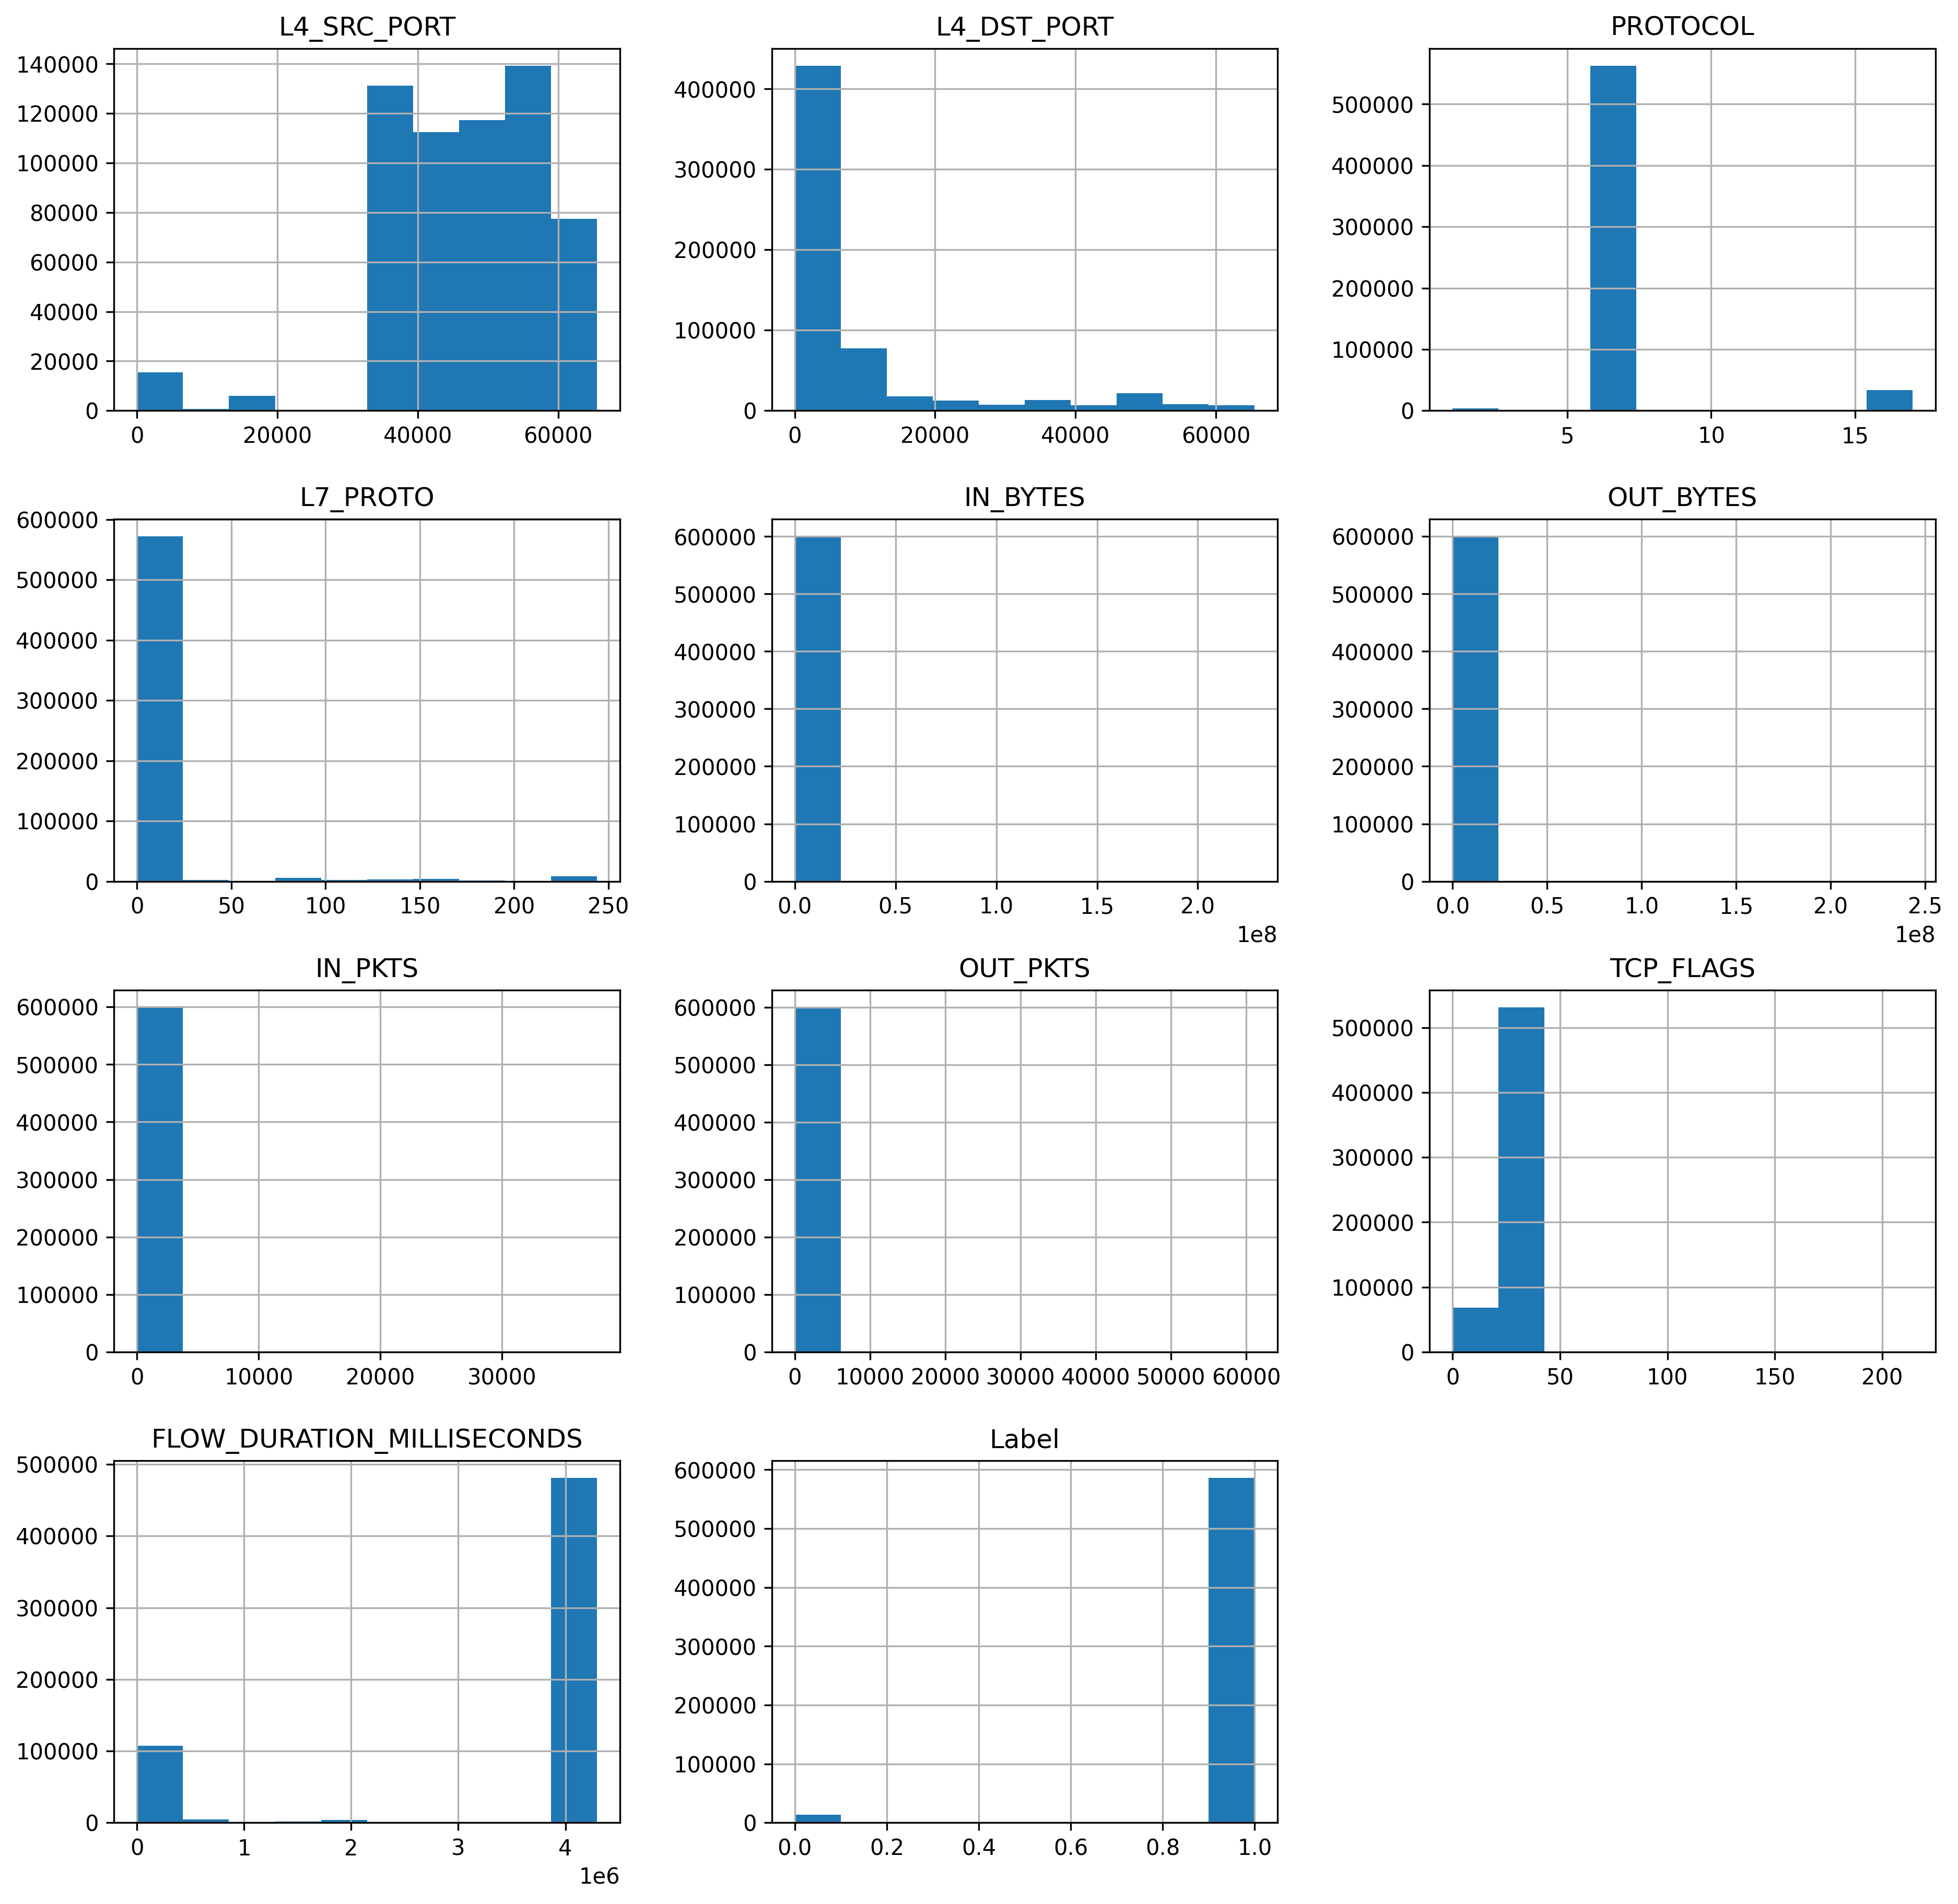

In [32]:
# print histogram for each parameter

figure(figsize=(15, 15), dpi=200)
data.hist(figsize=(15,15))



plt.show()    

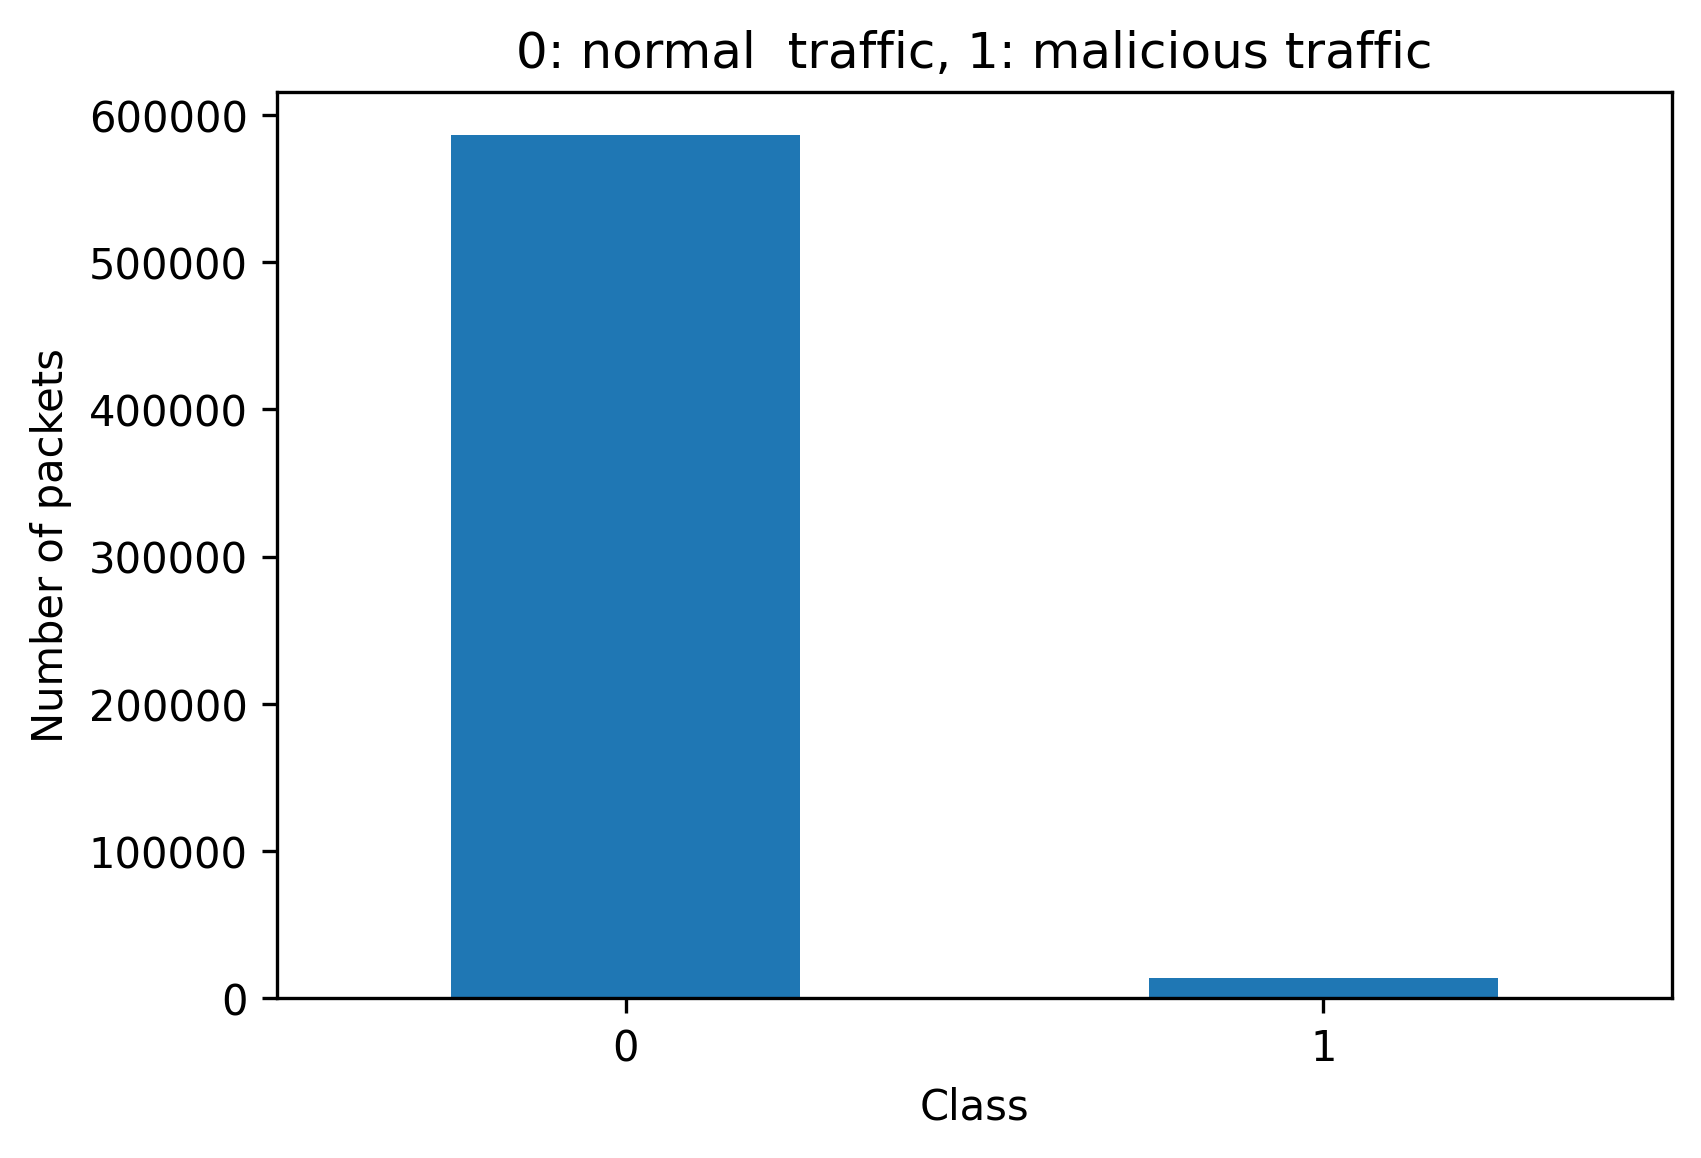

In [33]:
count_classes = pd.value_counts(data['Label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)


plt.xticks(range(len(data['Label'].unique())), data.Label.unique())
plt.title("0: normal  traffic, 1: malicious traffic")
plt.xlabel("Class")
plt.ylabel("Number of packets");

In [34]:
dataPSA=data
dataPSA['IPV4_SRC_ADDR'] = dataPSA.IPV4_SRC_ADDR.apply(str)
dataPSA['L4_SRC_PORT'] = dataPSA.L4_SRC_PORT.apply(str)
dataPSA['IPV4_DST_ADDR'] = dataPSA.IPV4_DST_ADDR.apply(str)
dataPSA['L4_DST_PORT'] = dataPSA.L4_DST_PORT.apply(str)

#dataPSA["id"]=dataPSA.index.tolist()
#dataPSA["id"]=dataPSA.id.apply(str)

dataPSA['IPV4_SRC'] = dataPSA['IPV4_SRC_ADDR'].apply(lambda x: int(x.split('.')[0]))##############
dataPSA['IPV4_DST'] = dataPSA['IPV4_DST_ADDR'].apply(lambda x: int(x.split('.')[0]))##############

dataPSA['IPV4_SRC_ADDR'] = dataPSA['IPV4_SRC_ADDR'] + ':' + dataPSA['L4_SRC_PORT'] # + ':' + dataPSA["id"]
dataPSA['IPV4_DST_ADDR'] = dataPSA['IPV4_DST_ADDR'] + ':' + dataPSA['L4_DST_PORT'] # + ':' + dataPSA["id"]
#dataPSA.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

Label=dataPSA.Label

dataPSA.drop(columns=['Attack','Label'],inplace = True)
#dataPSA.drop(columns=['id'],inplace = True)


cols_to_norm =  list(set(list(dataPSA.iloc[:,:].columns ))  - set(list(['Label','IPV4_DST_ADDR','IPV4_SRC_ADDR','IPV4_SRC','IPV4_DST'])) )
#cols_to_norm= list([ 'L4_SRC_PORT', 'L4_DST_PORT','PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS','TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS' ])
scaler = StandardScaler()
dataPSA[cols_to_norm] = scaler.fit_transform(dataPSA[cols_to_norm])

data=  dataPSA
data['x'] = data[ cols_to_norm ].values.tolist()
data['y']= Label
#data = data.sample(frac=1)

In [8]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC,IPV4_DST,x,y
0,192.168.100.6:52670,0.510211,192.168.100.1:53,-0.559990,4.057229,-0.107074,-0.019328,-0.008366,-0.046478,-0.024534,-2.693379,0.496161,192,192,"[-0.046478479394393736, -0.008365796184473941,...",0
1,192.168.100.6:49160,0.218595,192.168.100.149:4444,-0.248596,-0.227830,-0.256119,459.883098,0.233866,18.327208,21.122548,0.264141,0.424882,192,192,"[18.327207829922944, 0.23386631369790992, -0.2...",1
2,192.168.100.46:3456,-3.578560,192.168.100.5:80,-0.558075,4.057229,-0.256119,17.949784,10.848759,36.883818,47.436247,-2.693379,0.424682,192,192,"[36.88381800736401, 10.848758979063199, 4.0572...",0
3,192.168.100.3:80,-3.859043,192.168.100.55:8080,0.009255,-0.227830,-0.055944,17.810637,10.964454,36.883818,47.436247,-2.693379,0.424682,192,192,"[36.88381800736401, 10.964453925792734, -0.227...",0
4,192.168.100.46:80,-3.859043,192.168.100.5:80,-0.558075,-0.227830,-0.055944,17.668218,-0.008519,36.883818,-0.029759,-2.693379,0.424682,192,192,"[36.88381800736401, -0.008519189320487593, -0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600095,192.168.100.46:80,-3.859043,192.168.100.5:80,-0.558075,-0.227830,-0.055944,4.901707,-0.008519,10.205388,-0.029759,-2.693379,0.476991,192,192,"[10.205388085229128, -0.008519189320487593, -0...",0
600096,192.168.100.5:0,-3.865689,192.168.100.3:0,-0.563748,-0.227830,-0.256119,2.207503,-0.008519,6.099763,-0.029759,-2.693379,0.477006,192,192,"[6.099763489563086, -0.008519189320487593, -0....",0
600097,192.168.100.7:365,-3.835365,192.168.100.3:565,-0.523681,4.057229,-0.256119,0.112360,-0.008519,5.465627,-0.029759,-2.693379,0.477006,192,192,"[5.4656274134008065, -0.008519189320487593, 4....",0
600098,192.168.100.3:50850,0.359003,13.54.166.67:8883,0.066201,-0.227830,6.097379,0.004388,-0.006493,0.079536,0.137412,0.264141,0.478130,192,13,"[0.07953574086862339, -0.0064934260004342855, ...",0


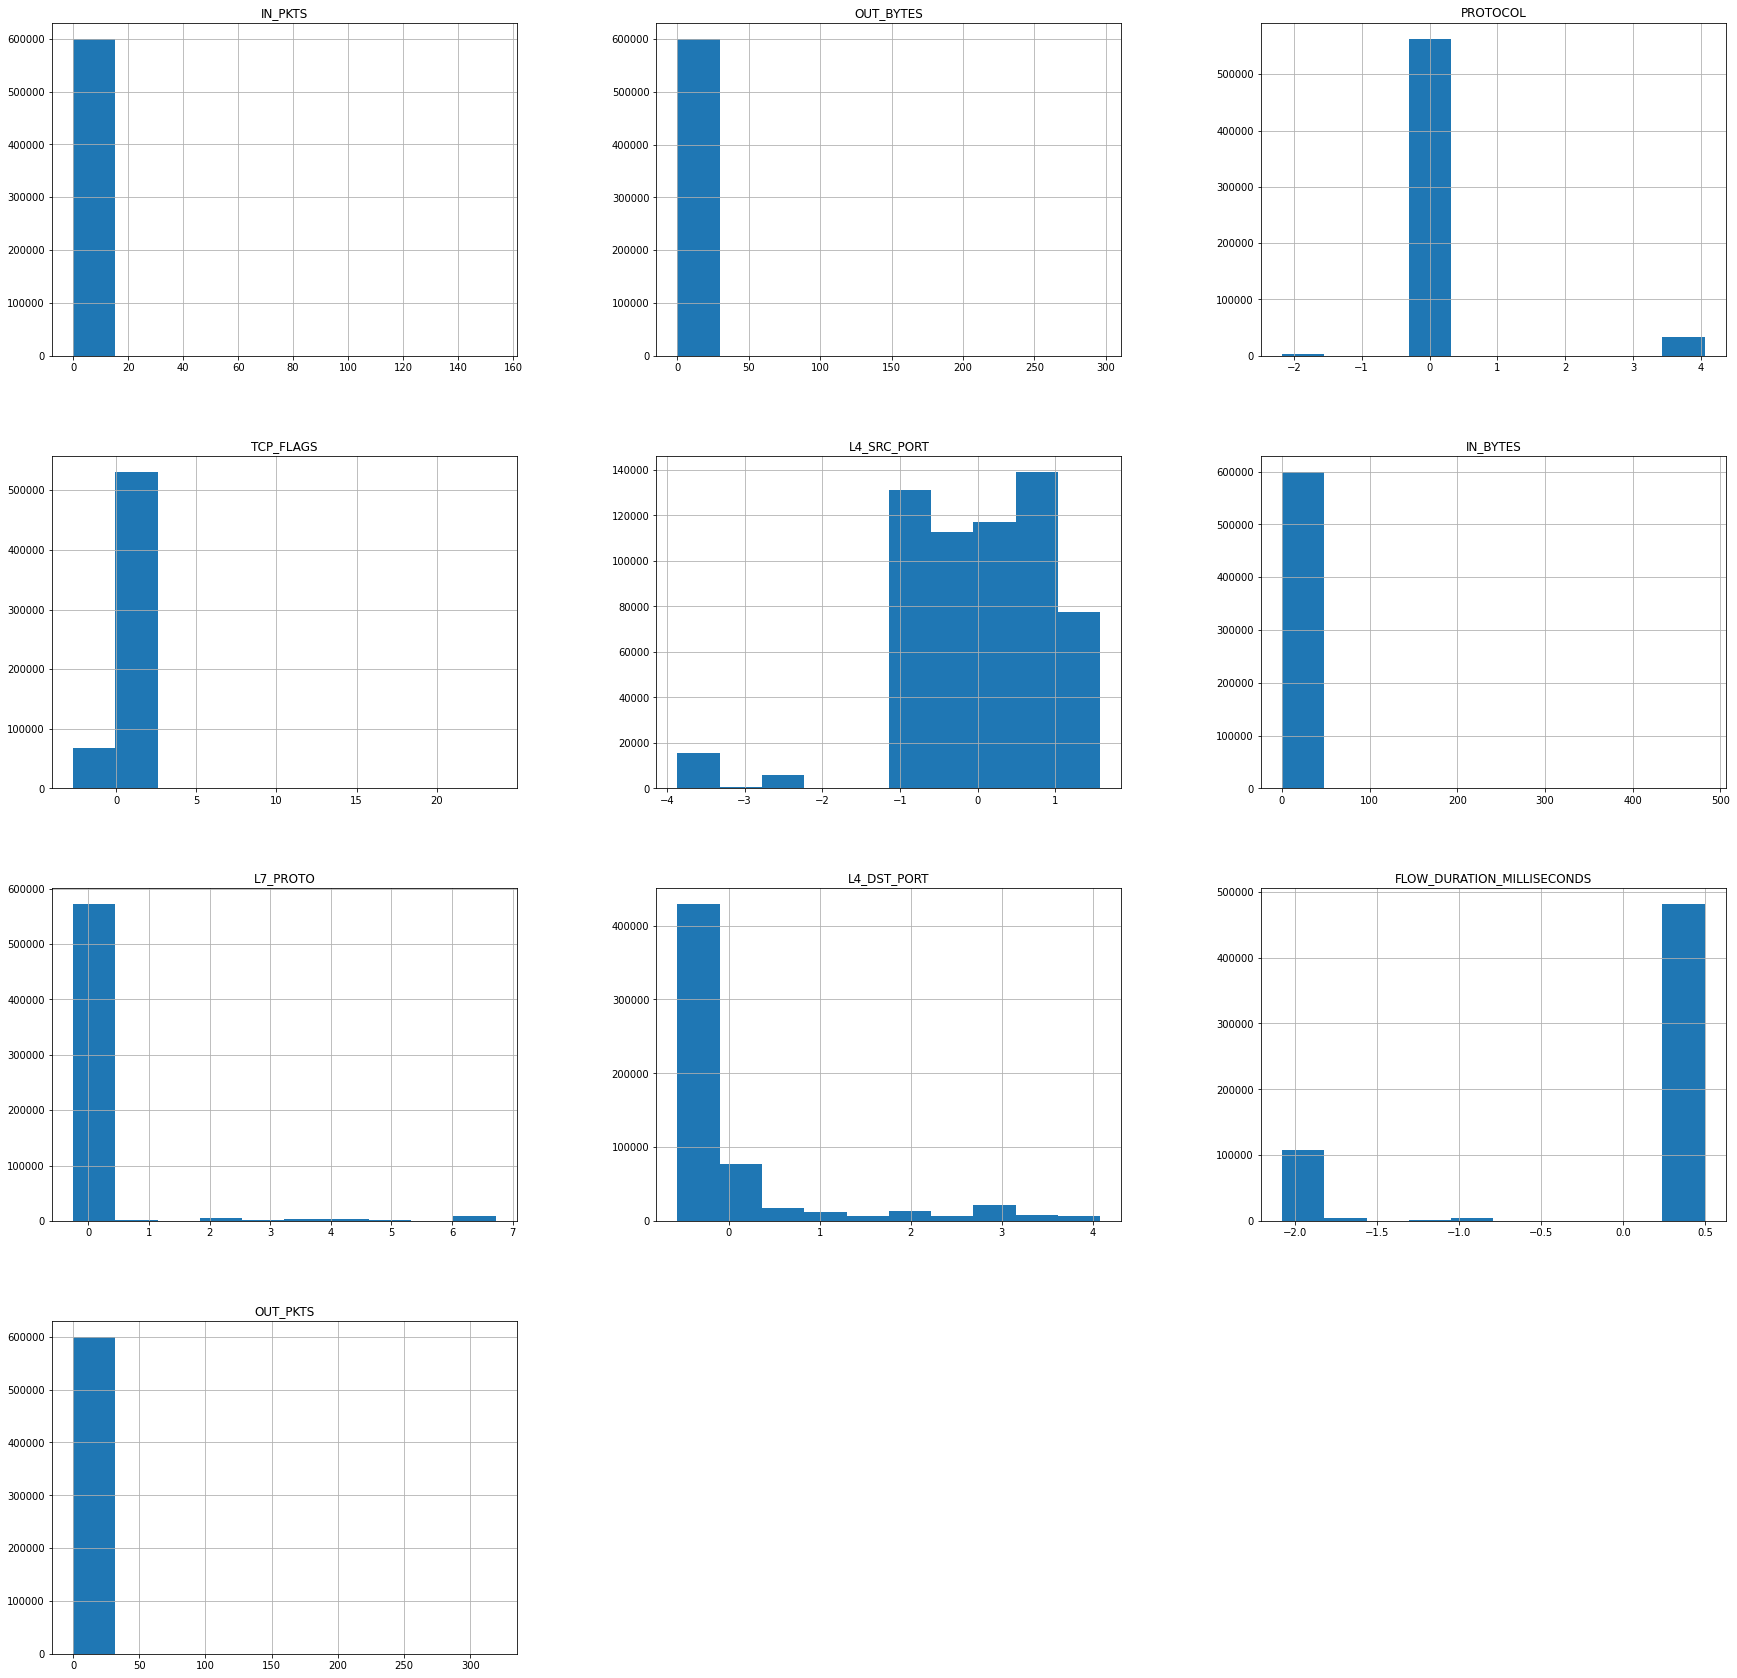

In [9]:
data[cols_to_norm].hist(figsize=(30,30))
plt.show()

In [10]:
import seaborn as sns

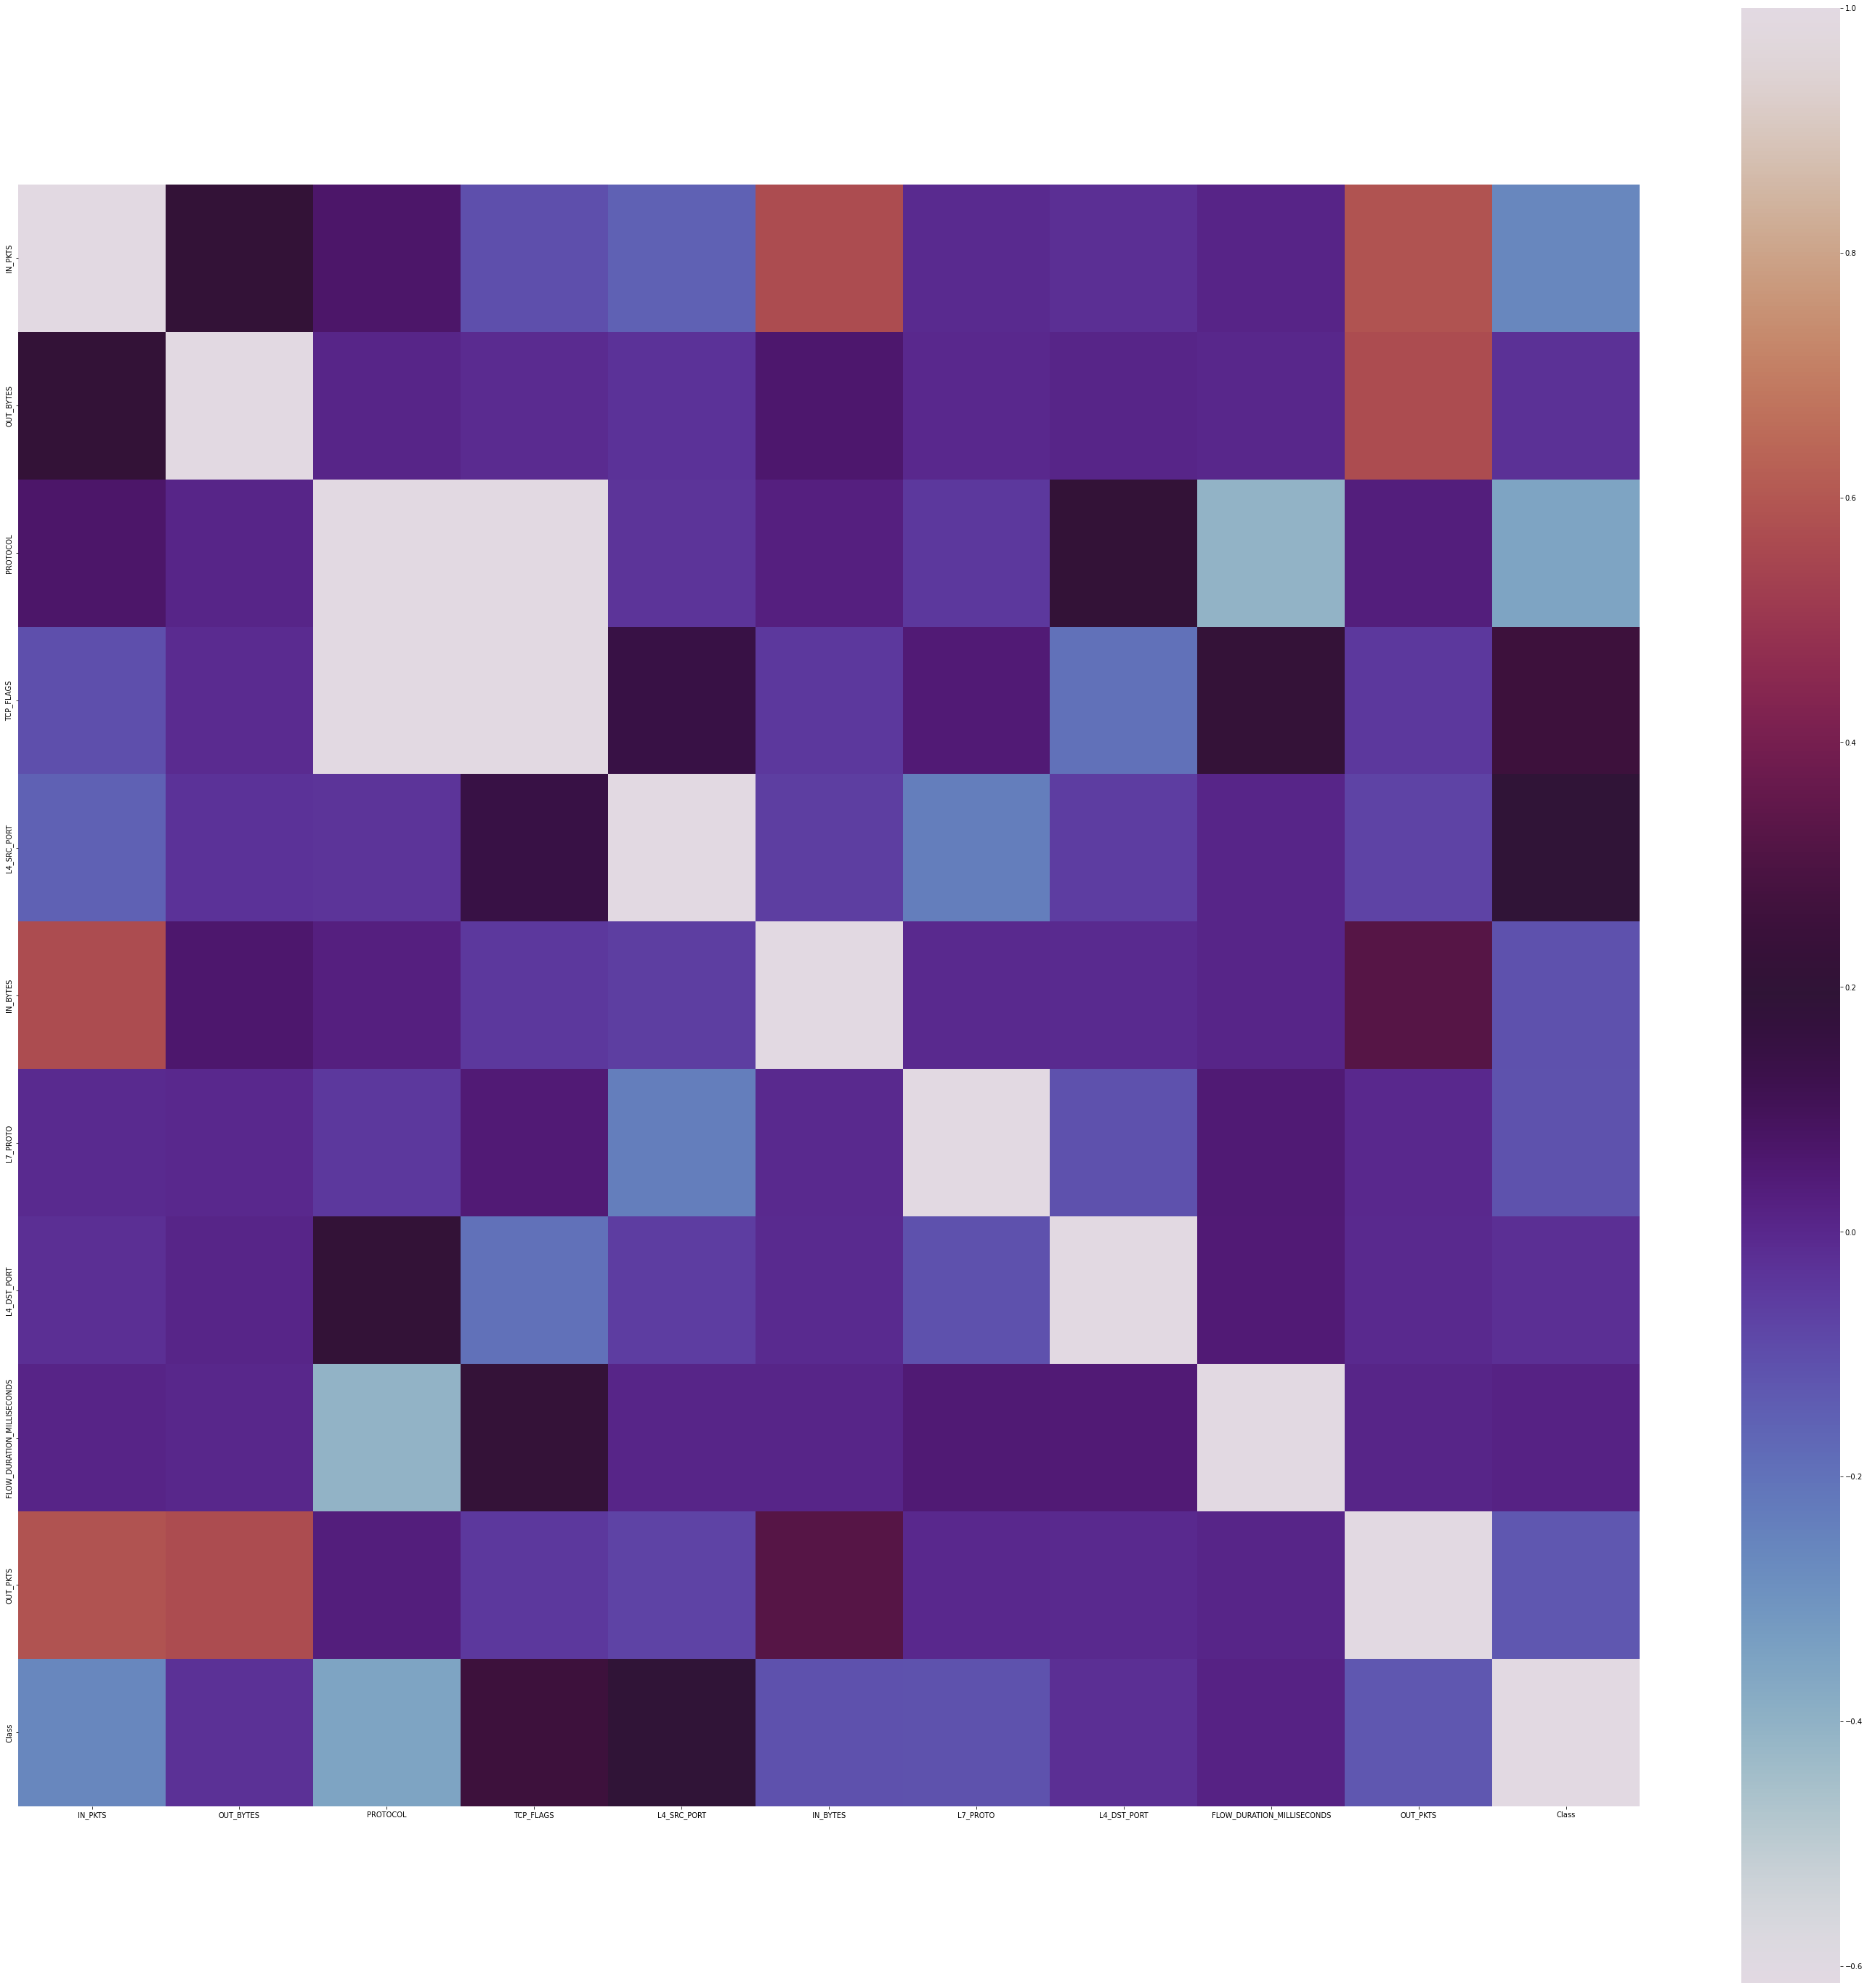

In [11]:
XstdY = data[cols_to_norm].copy()
XstdY['Class'] = data['y']
cormat = XstdY.corr()
fig = plt.figure(figsize=(50,50))

sns.heatmap(cormat, square=True, cmap=plt.cm.twilight)
plt.show()

<AxesSubplot:>

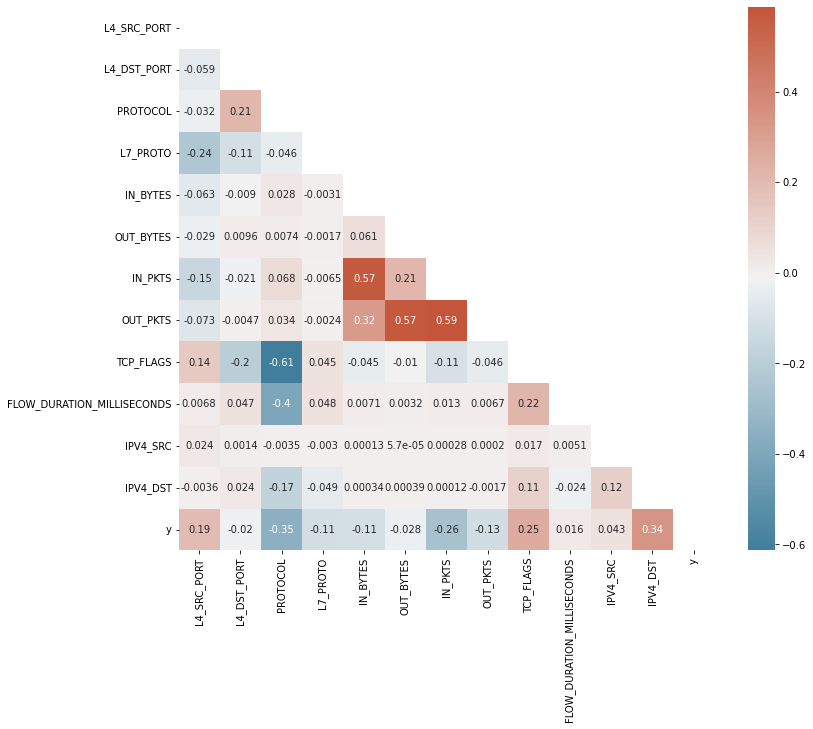

In [12]:

# Correlation between different variables
#
corr = data.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
